# Intel Image Classification

## Team Members: Sai Srinivas Lakkoju, Sudhanshu Dotel, Sai Avinash Nadakuditi

Hello! In this notebook, we explored the process of building and evaluating image classification models using convolutional neural networks (CNNs) and the Keras library. Here's an overview of our collaborative work:

Project Setup: We began by importing the necessary libraries and packages for image processing, neural network construction, and data manipulation.

Data Preparation: We loaded the image dataset as a team, ensuring that we understood the distribution of images across the different classes. To prepare the images for the CNN model, we visualized a sample of them, then collectively resized and normalized the pixel values.

Simple CNN Implementation:  We designed a basic convolutional neural network architecture together. This included convolutional layers for feature extraction, max pooling layers to reduce image dimensionality, and dense layers for the final classification. We then trained this model on the prepared image data.

Model Evaluation: As a group, we calculated performance metrics such as accuracy to evaluate how well our initial CNN model learned to classify the images.  Using these results, we collaborated on basic error analysis to identify potential areas for improvement.

Leveraging Transfer Learning: To enhance the model's performance, we worked together to fine-tune a pre-trained image classification model (like VGG16) on our specific image dataset. We experimented with freezing and training different layers of the pre-trained model to see the impact on results.

# Import Packages

In [1]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm
import pandas as pd

In [2]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

# Loading the Data
We wrote a load_data function that loaded the images and their labels from the folder.

In [3]:
def load_data():
    """
    Load the data from predefined training and testing directories:
    - 14,034 images to train the network.
    - 3,000 images to evaluate how accurately the network learned to classify images.
    """
    # Directories for training and testing datasets
    data_dirs = [
        'C:\\Users\\SRINIVAS\\Downloads\\archive\\seg_train\\seg_train',
        'C:\\Users\\SRINIVAS\\Downloads\\archive\\seg_test\\seg_test'
    ]
    output = []

    # Process each dataset
    for dataset in data_dirs:
        images, labels = [], []

        print(f"Loading {dataset}")

        # Process each category folder
        for folder in os.listdir(dataset):
            folder_path = os.path.join(dataset, folder)
            label = class_names_label[folder]

            # Process each image in the category folder
            for file in tqdm(os.listdir(folder_path)):
                img_path = os.path.join(folder_path, file)
                
                # Load, convert, and resize the image
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE)

                # Append the image and label to their respective lists
                images.append(image)
                labels.append(label)

        # Convert lists to numpy arrays
        images = np.array(images, dtype='float32')
        labels = np.array(labels, dtype='int32')

        # Append the dataset tuple to the output list
        output.append((images, labels))

    return output[0], output[1]

In [4]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading C:\Users\SRINIVAS\Downloads\archive\seg_train\seg_train


100%|██████████| 2382/2382 [00:04<00:00, 500.48it/s]


Loading C:\Users\SRINIVAS\Downloads\archive\seg_test\seg_test


100%|██████████| 501/501 [00:00<00:00, 786.41it/s]


In [6]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=42)

In [7]:
random_seed = 42
tf.random.set_seed(random_seed)
np.random.seed(random_seed)

# Exploratory Data Analysis


In [8]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 14034
Number of testing examples: 3000
Each image is of size: (150, 150)


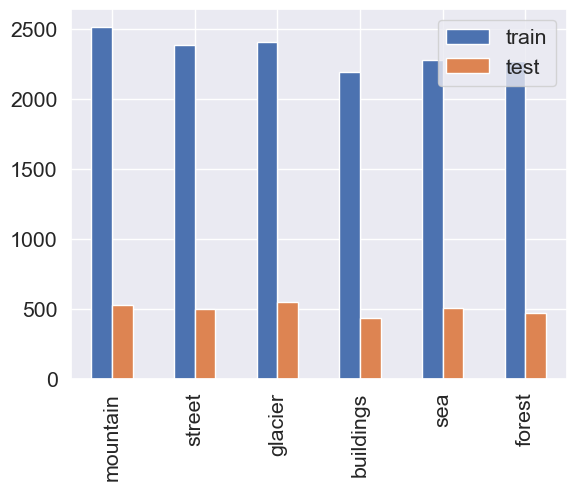

In [9]:
_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

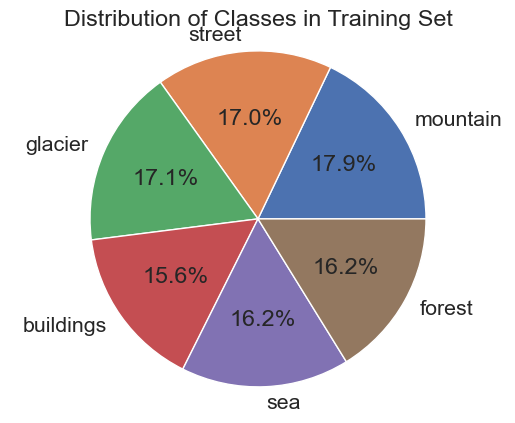

In [10]:
# Create pie chart slices based on training data counts

plt.pie(train_counts, labels=class_names, autopct="%1.1f%%")
plt.axis('equal')
plt.title('Distribution of Classes in Training Set')
plt.show()

## Scaling the Data

In [11]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

## Visualize the data
Lets Display Random Images from the Training Data

In [12]:
def display_examples(class_names, images, labels):
    """Displays a grid of 25 sample images with their labels."""

    fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)

    for image, label, ax in zip(images[:25], labels[:25], axes.flatten()):
        ax.imshow(image, cmap=plt.cm.binary)
        ax.set_xlabel(class_names[label])
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

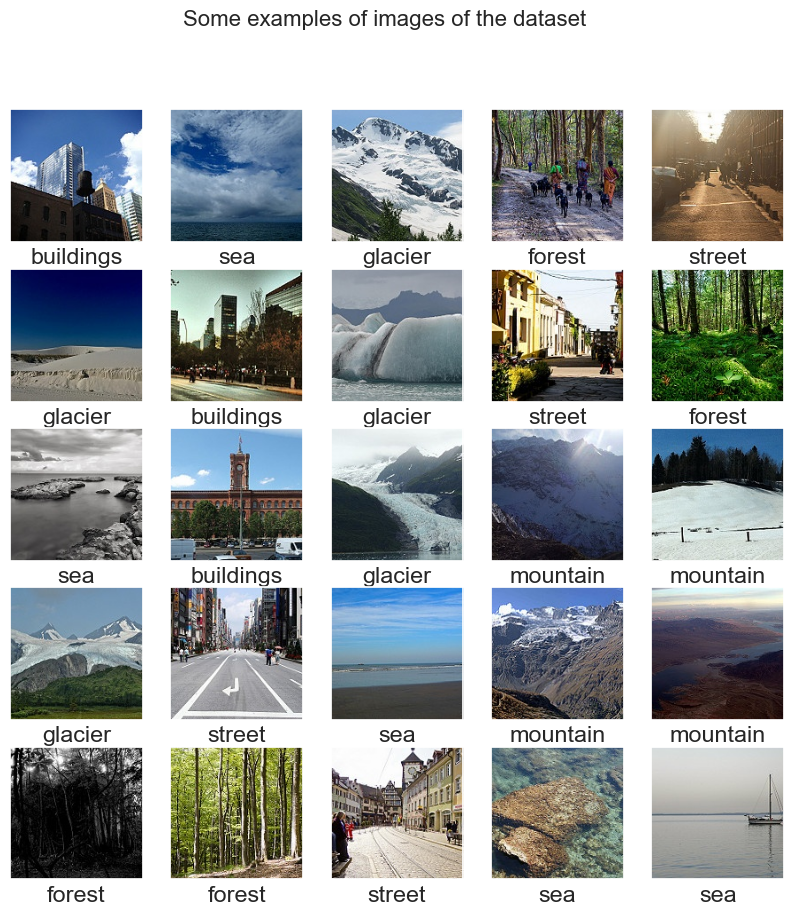

In [13]:
display_examples(class_names, train_images, train_labels)

# Simple Model Creation

Convolutional Layer 1:

Filters (32): The layer learns 32 filters, each of size 3x3. These filters act as feature detectors, scanning the input image (assumed to be 150x150 pixels with 3 color channels) and identifying low-level features like edges, corners, and basic shapes.
Max Pooling Layer 1:

Pooling Size (2x2): This layer performs downsampling. It divides the feature maps from the previous layer into non-overlapping 2x2 grids and retains the maximum value from each grid. This reduces the spatial dimensionality of the data by half (resulting in 75x75 feature maps with 32 channels) while capturing the most prominent features.
Convolutional Layer 2:

Similar to Layer 1: This layer functions similarly to the first convolutional layer, using 32 filters of size 3x3 with a ReLU activation function. It extracts more complex features based on the lower-level features detected earlier.
Max Pooling Layer 2:

Similar to Layer 1: It again performs downsampling with a 2x2 pooling window, reducing the spatial resolution of the feature maps by half (resulting in 38x38 feature maps with 32 channels).
Flatten Layer:

Reshaping Data: This layer transforms the 3D feature maps (each representing spatial locations and feature channels) into a 1D vector. This allows connection to the fully connected layers, which require a flattened input.
Dense Layer 1:

Neurons (128): This is the first fully connected layer, containing 128 neurons. It takes the flattened feature vector as input and performs a matrix multiplication to learn complex relationships between the features. The ReLU activation function introduces non-linearity, allowing the network to model non-linear relationships between features and class probabilities.
Dense Layer 2 (Output Layer):

Neurons (6): This final layer has 6 neurons, corresponding to the 6 image classes the model is designed to classify. It also uses a Softmax activation function. Softmax ensures the output values sum to 1 and represent probabilities for each class.

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

Then, we can compile it with some parameters such as:
* **Optimizer**: adam or RMSProp
* RMSProp = exponentially weighted average of the squares of past gradients.
* **Loss function**: we use sparse categorical crossentropy for classification, each images belongs to one class only

In [15]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

We fit the model to the data from the training set. The neural network will learn by itself the pattern in order to distinguish each category.

In [18]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=10, validation_split = 0.2)

Epoch 1/10


88/88 [==============================] - 109s 1s/step - loss: 0.0889 - accuracy: 0.9753 - val_loss: 0.8996 - val_accuracy: 0.7656
Epoch 2/10
88/88 [==============================] - 103s 1s/step - loss: 0.0603 - accuracy: 0.9870 - val_loss: 1.0108 - val_accuracy: 0.7585
Epoch 3/10
88/88 [==============================] - 114s 1s/step - loss: 0.0523 - accuracy: 0.9887 - val_loss: 1.0491 - val_accuracy: 0.7766
Epoch 4/10
88/88 [==============================] - 134s 2s/step - loss: 0.0337 - accuracy: 0.9948 - val_loss: 1.0832 - val_accuracy: 0.7581
Epoch 5/10
88/88 [==============================] - 131s 1s/step - loss: 0.0297 - accuracy: 0.9947 - val_loss: 1.1166 - val_accuracy: 0.7563
Epoch 6/10
88/88 [==============================] - 135s 2s/step - loss: 0.0356 - accuracy: 0.9930 - val_loss: 1.1992 - val_accuracy: 0.7592
Epoch 7/10
88/88 [==============================] - 120s 1s/step - loss: 0.0200 - accuracy: 0.9973 - val_loss: 1.2369 - val_accuracy: 0.7585
Epoch 8/10
88/88 [======

In [19]:
def plot_accuracy_loss(history):
    """
        Ploting the accuracy and the loss during the training of the Neural Network.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'], 'bo--', label="acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label="val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

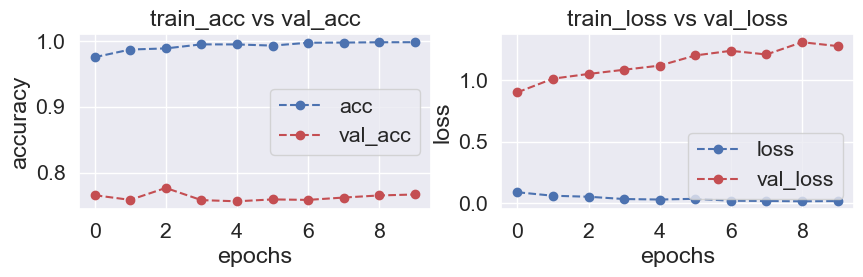

In [20]:
plot_accuracy_loss(history)

## Model Evaluation on Test Data

In [21]:
test_loss = model.evaluate(test_images, test_labels)

94/94 [==============================] - 10s 101ms/step - loss: 1.2854 - accuracy: 0.7630


We see that we achieve 0.76 accuracy on the testing test. We got a slight underfitting


## Error analysis

We can try to understand on which kind of images the classifier has trouble.

In [24]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

94/94 [==============================] - 5s 55ms/step


In [22]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)


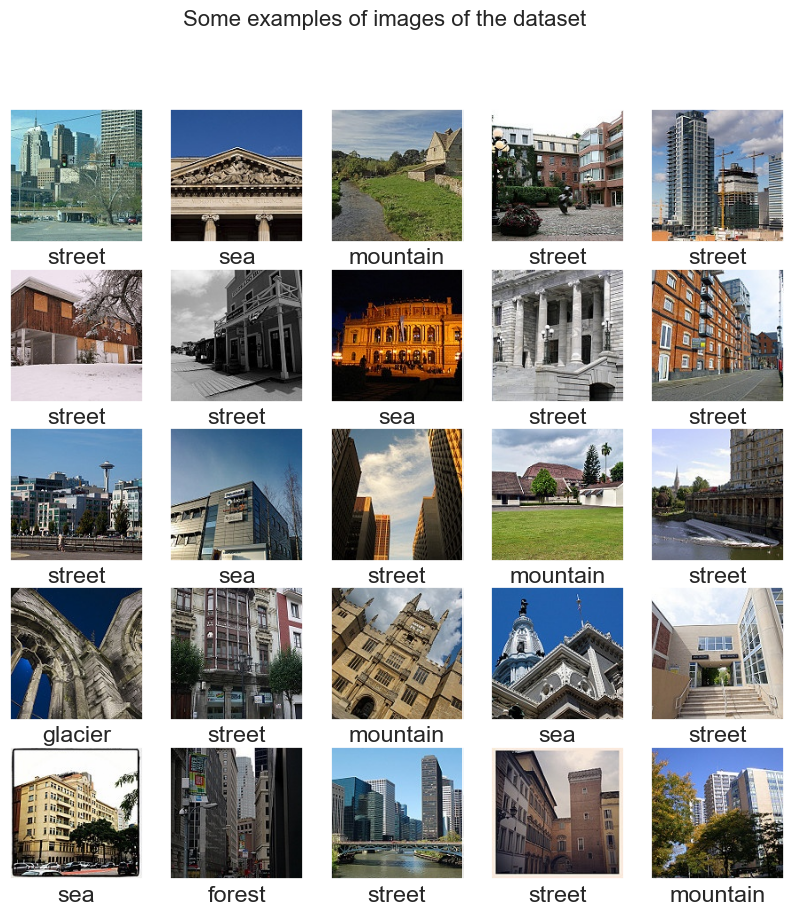

In [25]:
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

[[372   4  76  11  61   1]
 [  5 416   5  40  14  21]
 [ 89   9 402   6  43   4]
 [ 25  88  12 277  29   6]
 [ 59   6  45  13 385   2]
 [  2  26   3   5   1 437]]


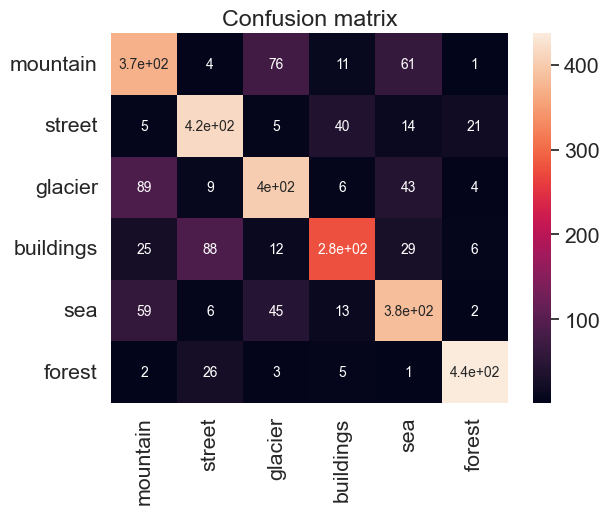

In [26]:
CM = confusion_matrix(test_labels, pred_labels)
print(CM)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

## Key Findings:
Specific Challenges: The classifier exhibits particular difficulty in distinguishing between these image categories:
Street and Building: This confusion is understandable due to the frequent presence of buildings within street scenes.
Sea, Glacier, and Mountain: Similarities in texture and color likely contribute to the misclassifications among these categories.

Area of Success: The model demonstrates high accuracy in correctly identifying forest images.

# Feature extraction with VGG ImageNet

We can extract features from VGG16.

In [27]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

model = VGG16(weights='imagenet', include_top=False)

In [28]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

94/94 [==============================] - 238s 3s/step


## Visualize the features through PCA

In [29]:
n_train, x, y, z = train_features.shape
n_test, x, y, z = test_features.shape
numFeatures = x * y * z

In [30]:
from sklearn import decomposition

pca = decomposition.PCA(n_components = 2)

X = train_features.reshape((n_train, x*y*z))
pca.fit(X)

C = pca.transform(X)
C1 = C[:,0]
C2 = C[:,1]

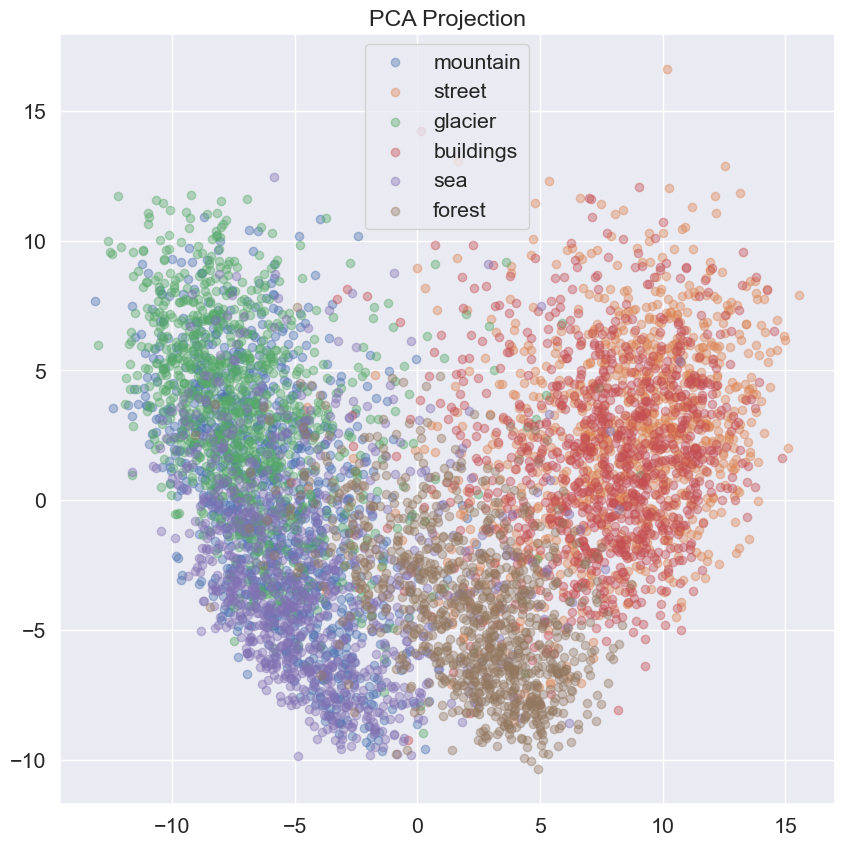

In [31]:
### Figures

plt.subplots(figsize=(10,10))

for i, class_name in enumerate(class_names):
    plt.scatter(C1[train_labels == i][:1000], C2[train_labels == i][:1000], label = class_name, alpha=0.4)
plt.legend()
plt.title("PCA Projection")
plt.show()

The PCA analysis reveals distinct clusters that generally align with the image labels. However, there are notable areas where the model struggles to differentiate between visually similar categories:

Glacier and Mountain:  The close proximity of glacier and mountain points in the PCA projection indicates that the VGG model perceives them as having very similar feature representations.

Building and Street: These categories lack clear separation in the PCA space, suggesting that the model has difficulty identifying the unique characteristics that distinguish them.
 

## Training on top of VGG

Let's train a simple one-layer Neural Network on the features extracted from VGG.

In [32]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (x, y, z)),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

history2 = model2.fit(train_features, train_labels, batch_size=128, epochs=10, validation_split = 0.2)

Epoch 1/10
88/88 [==============================] - 2s 16ms/step - loss: 0.5180 - accuracy: 0.8138 - val_loss: 0.3875 - val_accuracy: 0.8582
Epoch 2/10
88/88 [==============================] - 1s 13ms/step - loss: 0.3018 - accuracy: 0.8912 - val_loss: 0.4088 - val_accuracy: 0.8586
Epoch 3/10
88/88 [==============================] - 1s 14ms/step - loss: 0.2326 - accuracy: 0.9165 - val_loss: 0.3775 - val_accuracy: 0.8611
Epoch 4/10
88/88 [==============================] - 1s 12ms/step - loss: 0.1879 - accuracy: 0.9345 - val_loss: 0.4041 - val_accuracy: 0.8625
Epoch 5/10
88/88 [==============================] - 1s 11ms/step - loss: 0.1741 - accuracy: 0.9352 - val_loss: 0.3770 - val_accuracy: 0.8614
Epoch 6/10
88/88 [==============================] - 1s 10ms/step - loss: 0.1421 - accuracy: 0.9520 - val_loss: 0.3788 - val_accuracy: 0.8668
Epoch 7/10
88/88 [==============================] - 1s 14ms/step - loss: 0.1221 - accuracy: 0.9612 - val_loss: 0.3913 - val_accuracy: 0.8682
Epoch 8/10
88

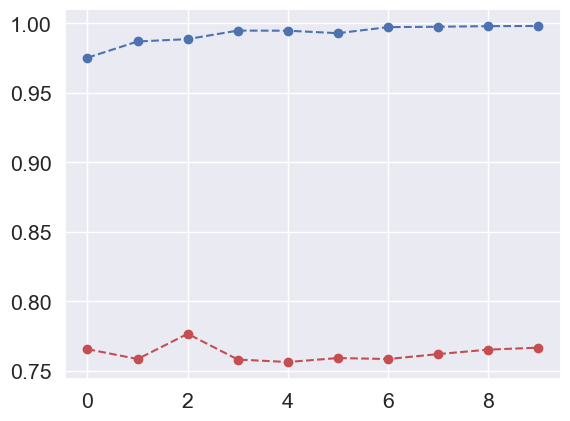

In [33]:
plt.plot(history.history['accuracy'], 'bo--', label = "acc") 
plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc") 

In [34]:
test_loss = model2.evaluate(test_features, test_labels)

94/94 [==============================] - 0s 4ms/step - loss: 0.3926 - accuracy: 0.8760


# Ensemble Neural Networks

In [35]:
n_estimators = 10
max_samples = 0.8
max_samples *= n_train
max_samples = int(max_samples)

We define n_estimators Neural Networks. 

Each Neural Network will be trained on random subsets of the training dataset. Each subset contains max_samples samples.

In [36]:
models = list()
random = np.random.randint(50, 100, size = n_estimators)

for i in range(n_estimators):
    
    # Model
    model = tf.keras.Sequential([ tf.keras.layers.Flatten(input_shape = (x, y, z)),
                                # One layer with random size
                                    tf.keras.layers.Dense(random[i], activation=tf.nn.relu),
                                    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
                                ])
    
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Store model
    models.append(model)

In [37]:
histories = []

for i in range(n_estimators):
    train_idx = np.random.choice(len(train_features), size = max_samples)
    histories.append(models[i].fit(train_features[train_idx], train_labels[train_idx], batch_size=128, epochs=10, validation_split = 0.2))

Epoch 1/10
71/71 [==============================] - 2s 16ms/step - loss: 0.5387 - accuracy: 0.7977 - val_loss: 0.3720 - val_accuracy: 0.8664
Epoch 2/10
71/71 [==============================] - 1s 14ms/step - loss: 0.2666 - accuracy: 0.9057 - val_loss: 0.4151 - val_accuracy: 0.8522
Epoch 3/10
71/71 [==============================] - 1s 14ms/step - loss: 0.2002 - accuracy: 0.9301 - val_loss: 0.3037 - val_accuracy: 0.8882
Epoch 4/10
71/71 [==============================] - 1s 17ms/step - loss: 0.1486 - accuracy: 0.9533 - val_loss: 0.3237 - val_accuracy: 0.8842
Epoch 5/10
71/71 [==============================] - 1s 16ms/step - loss: 0.1167 - accuracy: 0.9639 - val_loss: 0.2655 - val_accuracy: 0.9083
Epoch 6/10
71/71 [==============================] - 1s 16ms/step - loss: 0.0949 - accuracy: 0.9709 - val_loss: 0.2600 - val_accuracy: 0.9185
Epoch 7/10
71/71 [==============================] - 1s 14ms/step - loss: 0.0813 - accuracy: 0.9756 - val_loss: 0.2565 - val_accuracy: 0.9207
Epoch 8/10
71

We aggregate each model individual predictions to form a final prediction.

In [38]:
predictions = []
for i in range(n_estimators):
    predictions.append(models[i].predict(test_features))
    
predictions = np.array(predictions)
predictions = predictions.sum(axis = 0)
pred_labels = predictions.argmax(axis=1)

94/94 [==============================] - 1s 5ms/step


In [39]:
from sklearn.metrics import accuracy_score
print("Accuracy : {}".format(accuracy_score(test_labels, pred_labels)))

Accuracy : 0.887


# Fine Tuning VGG ImageNet

In [40]:
from keras.models import Model

model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=model.inputs, outputs=model.layers[-5].output)

In [41]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

94/94 [==============================] - 226s 2s/step


In [42]:
from keras.layers import Input, Dense, Conv2D, Activation , MaxPooling2D, Flatten

model2 = VGG16(weights='imagenet', include_top=False)

input_shape = model2.layers[-4].get_input_shape_at(0) 
layer_input = Input(shape = (9, 9, 512)) 

x = layer_input
for layer in model2.layers[-4::1]:
    x = layer(x)
    
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(100,activation='relu')(x)
x = Dense(6,activation='softmax')(x)

# create the model
new_model = Model(layer_input, x)

In [43]:
new_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [44]:
new_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 9, 9, 512)]       0         
                                                                 
 block5_conv1 (Conv2D)       multiple                  2359808   
                                                                 
 block5_conv2 (Conv2D)       multiple                  2359808   
                                                                 
 block5_conv3 (Conv2D)       multiple                  2359808   
                                                                 
 block5_pool (MaxPooling2D)  multiple                  0         
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 64)          294976    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 1, 64)         0   

In [45]:
history = new_model.fit(train_features, train_labels, batch_size=128, epochs=10, validation_split = 0.2)

Epoch 1/10
88/88 [==============================] - 322s 4s/step - loss: 0.6808 - accuracy: 0.7305 - val_loss: 0.3555 - val_accuracy: 0.8735
Epoch 2/10
88/88 [==============================] - 350s 4s/step - loss: 0.3149 - accuracy: 0.8937 - val_loss: 0.2988 - val_accuracy: 0.8963
Epoch 3/10
88/88 [==============================] - 356s 4s/step - loss: 0.2473 - accuracy: 0.9136 - val_loss: 0.3378 - val_accuracy: 0.8849
Epoch 4/10
88/88 [==============================] - 366s 4s/step - loss: 0.1971 - accuracy: 0.9320 - val_loss: 0.3668 - val_accuracy: 0.8767
Epoch 5/10
88/88 [==============================] - 382s 4s/step - loss: 0.1876 - accuracy: 0.9352 - val_loss: 0.3125 - val_accuracy: 0.8974
Epoch 6/10
88/88 [==============================] - 371s 4s/step - loss: 0.1436 - accuracy: 0.9500 - val_loss: 0.3217 - val_accuracy: 0.9052
Epoch 7/10
88/88 [==============================] - 366s 4s/step - loss: 0.1260 - accuracy: 0.9564 - val_loss: 0.3562 - val_accuracy: 0.8949
Epoch 8/10
88

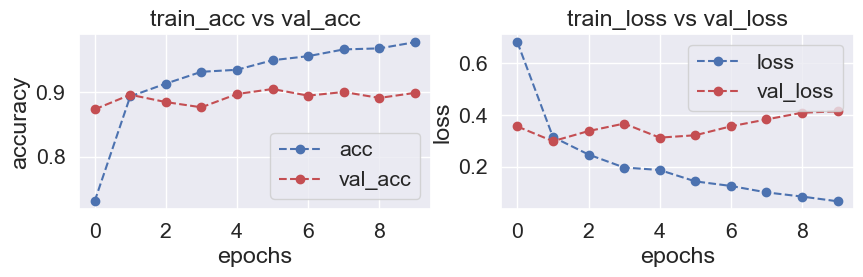

In [46]:
plot_accuracy_loss(history)

In [47]:
from sklearn.metrics import accuracy_score

predictions = new_model.predict(test_features)    
pred_labels = np.argmax(predictions, axis = 1)
print("Accuracy : {}".format(accuracy_score(test_labels, pred_labels)))

94/94 [==============================] - 11s 112ms/step
Accuracy : 0.9086666666666666


# Results and Conclusion

The project demonstrated the effectiveness of combining ensemble techniques with deep transfer learning to tackle the challenges of image classification. The ensemble approach provided a strong baseline by mitigating the risks of overfitting and improving generalization. Meanwhile, the fine-tuning of the VGG16 model effectively leveraged pre-learned features applicable to our specific task, which significantly boosted the performance.

This hybrid strategy not only enhanced classification accuracy but also highlighted the benefits of integrating multiple models and transfer learning techniques in complex tasks like image classification. Such approaches are scalable and adaptable, making them suitable for a variety of image recognition tasks in practical applications. This project serves as a proof of concept that can be expanded with more sophisticated models, larger datasets, and deeper integration of machine learning techniques to further push the boundaries of what can be achieved in the field of computer vision.